In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM


2025-05-01 14:36:59.704 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=None)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name = "yamask"
start_epoch=1
num_epochs=140
save_every=10
backup_every=20

# Hyper-parameters
BATCH_SIZE = 128
LR = 1e-3

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model
model = BaseDino(head_layers=5, head_hidden_size=512, dropout_rate=0.0, unfreeze_blocks=1)
model.to(device)

# Optimizer, scheduler, and loss function
mask = [torch.ones_like(p, device=p.device) for p in model.parameters()] # Must be done AFTER the model is moved to CUDA
optimizer = SparseSGDM(model.parameters(), mask=mask, lr=LR)
scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=20, eta_min=1e-5)
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 60
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
# Get one batch of data from the test dataloader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Move the data to the same device as the model
images = images.to(device)

# Perform prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Print the first prediction and its corresponding label
print(f"Predicted class: {predicted[0].item()}, True class: {labels[0].item()}")
print(f"Outputs shape: {outputs.shape}")

Predicted class: 51, True class: 49
Outputs shape: torch.Size([128, 100])


In [6]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: yamask



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 1/140 (0.71%) Completed
	📊 Training Loss: 4.2363
	✅ Training Accuracy: 9.70%
	⏳ Elapsed Time: 86.74s | ETA: 12057.30s
	🕒 Completed At: 14:38


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 3.4275
	🎯 Validation Accuracy: 25.24%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 2/140 (1.43%) Completed
	📊 Training Loss: 2.4603
	✅ Training Accuracy: 41.05%
	⏳ Elapsed Time: 86.85s | ETA: 11985.20s
	🕒 Completed At: 14:40


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.9358
	🎯 Validation Accuracy: 48.33%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 3/140 (2.14%) Completed
	📊 Training Loss: 1.5916
	✅ Training Accuracy: 57.23%
	⏳ Elapsed Time: 86.75s | ETA: 11885.30s
	🕒 Completed At: 14:42


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.08batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.4938
	🎯 Validation Accuracy: 58.40%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.62batch/s]


🚀 Epoch 4/140 (2.86%) Completed
	📊 Training Loss: 1.2867
	✅ Training Accuracy: 63.93%
	⏳ Elapsed Time: 86.37s | ETA: 11745.72s
	🕒 Completed At: 14:43


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.3738
	🎯 Validation Accuracy: 61.22%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 5/140 (3.57%) Completed
	📊 Training Loss: 1.1214
	✅ Training Accuracy: 67.91%
	⏳ Elapsed Time: 86.92s | ETA: 11734.32s
	🕒 Completed At: 14:45


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.3279
	🎯 Validation Accuracy: 62.97%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 6/140 (4.29%) Completed
	📊 Training Loss: 1.0086
	✅ Training Accuracy: 70.95%
	⏳ Elapsed Time: 87.32s | ETA: 11701.05s
	🕒 Completed At: 14:47


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.2257
	🎯 Validation Accuracy: 64.92%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 7/140 (5.00%) Completed
	📊 Training Loss: 0.9196
	✅ Training Accuracy: 73.32%
	⏳ Elapsed Time: 86.29s | ETA: 11476.19s
	🕒 Completed At: 14:49


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1476
	🎯 Validation Accuracy: 67.12%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 8/140 (5.71%) Completed
	📊 Training Loss: 0.8498
	✅ Training Accuracy: 75.27%
	⏳ Elapsed Time: 87.36s | ETA: 11531.23s
	🕒 Completed At: 14:50


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.03batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1037
	🎯 Validation Accuracy: 68.55%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 9/140 (6.43%) Completed
	📊 Training Loss: 0.7977
	✅ Training Accuracy: 76.55%
	⏳ Elapsed Time: 86.78s | ETA: 11367.82s
	🕒 Completed At: 14:52


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.07batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0692
	🎯 Validation Accuracy: 69.42%



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.54batch/s]


🚀 Epoch 10/140 (7.14%) Completed
	📊 Training Loss: 0.7436
	✅ Training Accuracy: 78.02%
	⏳ Elapsed Time: 88.46s | ETA: 11499.92s
	🕒 Completed At: 14:54


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.04batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0492
	🎯 Validation Accuracy: 69.37%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/yamask_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/yamask_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 313/313 [01:28<00:00,  3.55batch/s]


🚀 Epoch 11/140 (7.86%) Completed
	📊 Training Loss: 0.6995
	✅ Training Accuracy: 79.38%
	⏳ Elapsed Time: 88.07s | ETA: 11360.63s
	🕒 Completed At: 14:56


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0249
	🎯 Validation Accuracy: 70.36%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 12/140 (8.57%) Completed
	📊 Training Loss: 0.6603
	✅ Training Accuracy: 80.58%
	⏳ Elapsed Time: 86.63s | ETA: 11088.18s
	🕒 Completed At: 14:58


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0132
	🎯 Validation Accuracy: 70.85%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.61batch/s]


🚀 Epoch 13/140 (9.29%) Completed
	📊 Training Loss: 0.6328
	✅ Training Accuracy: 81.51%
	⏳ Elapsed Time: 86.68s | ETA: 11007.90s
	🕒 Completed At: 14:59


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.02batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.0022
	🎯 Validation Accuracy: 71.15%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.64batch/s]


🚀 Epoch 14/140 (10.00%) Completed
	📊 Training Loss: 0.5988
	✅ Training Accuracy: 82.54%
	⏳ Elapsed Time: 86.10s | ETA: 10848.05s
	🕒 Completed At: 15:01


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9809
	🎯 Validation Accuracy: 71.90%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 15/140 (10.71%) Completed
	📊 Training Loss: 0.5768
	✅ Training Accuracy: 83.34%
	⏳ Elapsed Time: 86.92s | ETA: 10864.76s
	🕒 Completed At: 15:03


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.00batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9642
	🎯 Validation Accuracy: 71.96%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.58batch/s]


🚀 Epoch 16/140 (11.43%) Completed
	📊 Training Loss: 0.5595
	✅ Training Accuracy: 83.91%
	⏳ Elapsed Time: 87.43s | ETA: 10841.42s
	🕒 Completed At: 15:05


Eval progress: 100%|██████████| 79/79 [00:20<00:00,  3.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9674
	🎯 Validation Accuracy: 72.23%



Training progress: 100%|██████████| 313/313 [01:30<00:00,  3.45batch/s]


🚀 Epoch 17/140 (12.14%) Completed
	📊 Training Loss: 0.5466
	✅ Training Accuracy: 84.43%
	⏳ Elapsed Time: 90.63s | ETA: 11148.05s
	🕒 Completed At: 15:06


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9553
	🎯 Validation Accuracy: 72.64%



Training progress: 100%|██████████| 313/313 [01:27<00:00,  3.59batch/s]


🚀 Epoch 18/140 (12.86%) Completed
	📊 Training Loss: 0.5344
	✅ Training Accuracy: 84.90%
	⏳ Elapsed Time: 87.22s | ETA: 10640.39s
	🕒 Completed At: 15:08


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.05batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9351
	🎯 Validation Accuracy: 73.14%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.63batch/s]


🚀 Epoch 19/140 (13.57%) Completed
	📊 Training Loss: 0.5239
	✅ Training Accuracy: 85.03%
	⏳ Elapsed Time: 86.35s | ETA: 10447.87s
	🕒 Completed At: 15:10


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.06batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9435
	🎯 Validation Accuracy: 72.90%



Training progress: 100%|██████████| 313/313 [01:26<00:00,  3.60batch/s]


🚀 Epoch 20/140 (14.29%) Completed
	📊 Training Loss: 0.5203
	✅ Training Accuracy: 85.16%
	⏳ Elapsed Time: 86.90s | ETA: 10427.49s
	🕒 Completed At: 15:12


Eval progress: 100%|██████████| 79/79 [00:19<00:00,  4.09batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9407
	🎯 Validation Accuracy: 72.97%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/yamask_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/yamask_BaseDino_epoch_20.loss_acc.json

Running backup for epoch 20
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_151237_yamask_BaseDino_epoch_20.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250501_151237_yamask_BaseDino_epoch_20.loss_acc.json



Training progress:  65%|██████▌   | 204/313 [00:56<00:30,  3.62batch/s]

Training interrupted manually.


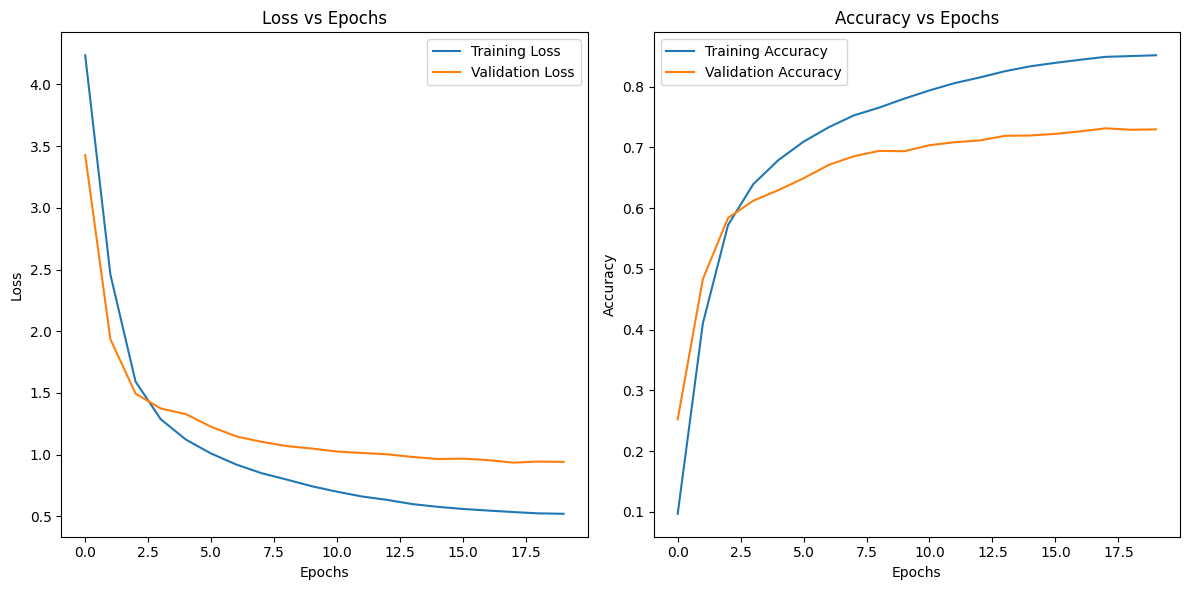

In [7]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 79/79 [00:18<00:00,  4.19batch/s]

🔍 Test Results:
	📉 Test Loss: 0.9133
	🎯 Test Accuracy: 73.49%
